In [30]:
!ls


drive  model.png  sample_data  train


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir train

In [0]:
!mkdir train/128

In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/input/grapheme-imgs-128x128.zip' train

In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/input/train.csv' train

In [0]:
#!cp '/content/drive/My Drive/kaggle/bengali/input/DenseNet-BC-121-32-no-top.h5' train

In [0]:
!unzip train/grapheme-imgs-128x128.zip  -d train/128/


In [31]:
!ls train

128  grapheme-imgs-128x128.zip	train.csv


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau,LambdaCallback
from tensorflow.keras import layers


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
os.chdir('/content/')

In [0]:
dataset_np = pd.read_csv('./train/train.csv').to_numpy()
train_dir='./train/128'

In [0]:
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]
split_rate = 0.1
valid_m = int(dataset_m*split_rate)
train_m = int(dataset_m-valid_m)
indicies=np.arange(dataset_m)
np.random.shuffle(indicies)
random_train_inds = indicies[0:train_m]
random_valid_inds = indicies[train_m:train_m+valid_m]
train_np = dataset_np[random_train_inds]
valid_np = dataset_np[random_valid_inds]
train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)
train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

In [0]:

inceptionV3 = InceptionV3(include_top=False, weights=None, input_shape=(128, 128, 3))


In [0]:
def build_model(inceptionV3):
    x_in = layers.Input(shape=(128, 128, 3))
    x = inceptionV3(x_in)
    
    #x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    out_root = tf.keras.layers.Dense(168, activation='softmax', name='root')(x)
    out_vowel = tf.keras.layers.Dense(11, activation='softmax', name='vowel')(x)
    out_consonant = tf.keras.layers.Dense(7, activation='softmax', name='consonant')(x)
    
    model = tf.keras.Model(inputs=x_in, outputs=[out_root, out_vowel, out_consonant])
    
    return model

In [0]:
model = build_model(inceptionV3)

loss_dict={'root': 'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
metrics_dict={ 'root':     [tf.keras.metrics.Recall(name='recall')],
               'vowel':    [tf.keras.metrics.Recall(name='recall')],
               'consonant':[tf.keras.metrics.Recall(name='recall')]}

initial_learningrate=1e-3
model.compile(optimizer=RMSprop(lr=initial_learningrate), loss=loss_dict, loss_weights=[2.0,1.0,1.0], 
                  metrics=metrics_dict)

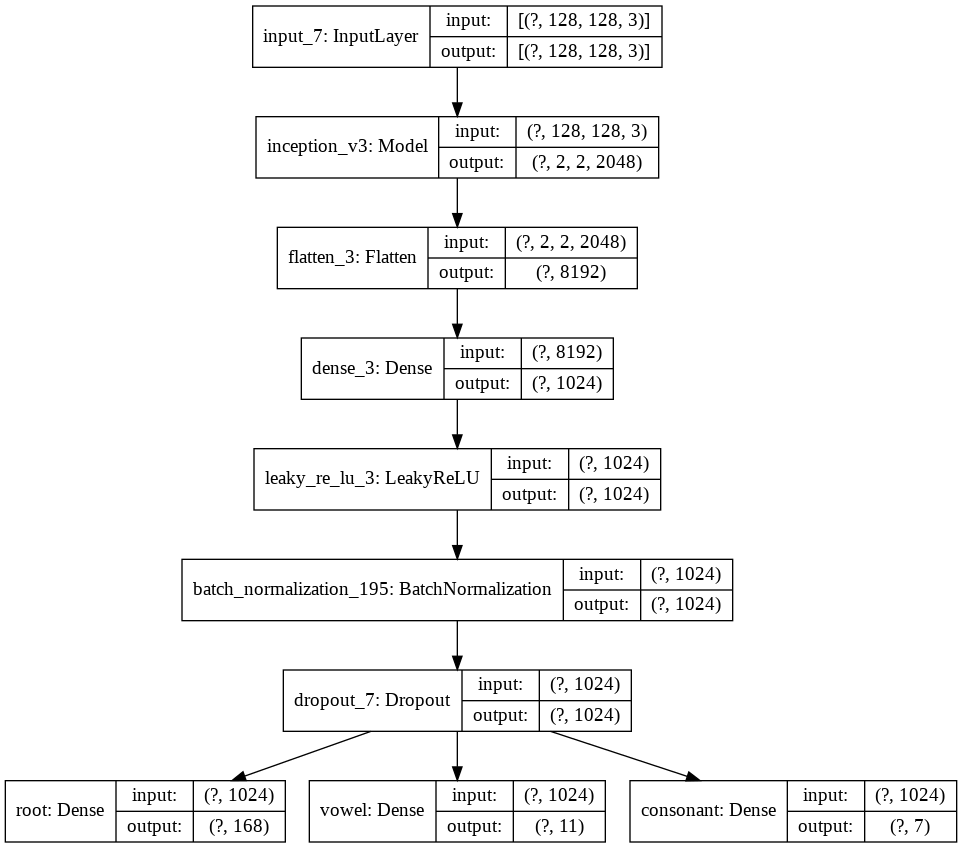

In [35]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   shear_range = 0.1)

valid_datagen = ImageDataGenerator() 

In [43]:
columns=["root_class","vowel_class", "cons_class"]
batch_size = 128
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col="filename",
        y_col=columns,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="multi_output",
        colormode="greyscale")

valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=train_dir,
        x_col="filename",
        y_col=columns,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="multi_output",
        colormode="greyscale")

Found 180756 validated image filenames.
Found 20084 validated image filenames.


In [44]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6203235280952614948, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13228523399185514239
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3985994277843435008
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 184808855800777429
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
def split_into_3_outputs(y_batch):
    
    y1=tf.keras.utils.to_categorical(y_batch[0],168)
    y2=tf.keras.utils.to_categorical(y_batch[1],11)
    y3=tf.keras.utils.to_categorical(y_batch[2],7)
    
    return y1,y2,y3

In [0]:
def aux_data_gen(generator):
    stats = (0.0692, 0.2051)
    while True:
        batch = next(generator)
        batch_x = (batch[0].astype(np.float32)/255.0 - stats[0])/stats[1]
        yield batch_x, split_into_3_outputs(batch[1])

In [0]:
import math
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [49]:

epochs = 15
ca_shed = CosineAnnealingScheduler(T_max=epochs, eta_max=initial_learningrate, eta_min=1e-6,verbose=1)

history=model.fit_generator(aux_data_gen(train_generator),
                    validation_data=aux_data_gen(valid_generator),
                    epochs=epochs,
                    steps_per_epoch=train_m//batch_size+1,
                    validation_steps = valid_m//batch_size+1,
                    callbacks=[ca_shed])

history.history['weighted_recall']= 0.5*np.array(history.history['root_recall'])+0.25*np.array(history.history['consonant_recall'])+0.25*np.array(history.history['vowel_recall'])
history.history['val_weighted_recall']= 0.5*np.array(history.history['val_root_recall'])+0.25*np.array(history.history['val_consonant_recall'])+0.25*np.array(history.history['val_vowel_recall'])

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 1413 steps, validate for 157 steps

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.001.
Epoch 1/15
1413/1413 [==============================] - 880s 622ms/step - loss: 8.1990 - root_loss: 3.2002 - vowel_loss: 0.9995 - consonant_loss: 0.7991 - root_recall: 0.2155 - vowel_recall: 0.5967 - consonant_recall: 0.6920 - val_loss: 7.0469 - val_root_loss: 2.6730 - val_vowel_loss: 1.1648 - val_consonant_loss: 0.5361 - val_root_recall: 0.3702 - val_vowel_recall: 0.7004 - val_consonant_recall: 0.8253

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.000989084726566536.
Epoch 2/15
1413/1413 [==============================] - 847s 600ms/step - loss: 1.7594 - root_loss: 0.6709 - vowel_loss: 0.2192 - consonant_loss: 0.1985 - root_recall: 0.7684 - vowel_recall: 0.9278 - consonant_recall: 0.9354 - val_loss: 4.2817 - val_root_loss: 1.7739 - val_vowel_loss: 0.3129 - val_consonant_loss: 0

In [0]:
model.save_weights('/content/drive/My Drive/kaggle/bengali/output/w_inceptionv3_eps15_sr01_rmsprop.h5')
model.save('/content/drive/My Drive/kaggle/bengali/output/m_inceptionv3_eps15_sr01_rmsprop.h5')
pd.DataFrame(history.history).to_csv('/content/drive/My Drive/kaggle/bengali/output/h_inceptionv3.csv', index=False)

In [51]:
model.optimizer.get_config()

{'centered': False,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 1.1915274e-05,
 'momentum': 0.0,
 'name': 'RMSprop',
 'rho': 0.9}

In [0]:
from matplotlib import pyplot as plt

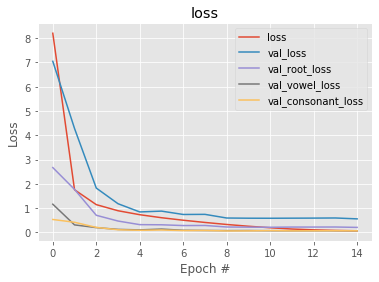

In [54]:
%matplotlib inline

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label='loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, epochs), history.history['val_root_loss'], label='val_root_loss')
plt.plot(np.arange(0, epochs), history.history['val_vowel_loss'], label='val_vowel_loss')
plt.plot(np.arange(0, epochs), history.history['val_consonant_loss'], label='val_consonant_loss')

    
plt.title('loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

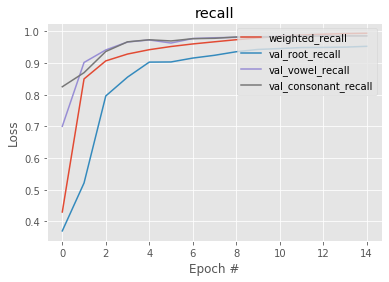

In [55]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['weighted_recall'], label='weighted_recall')
plt.plot(np.arange(0, epochs), history.history['val_root_recall'], label='val_root_recall')
plt.plot(np.arange(0, epochs), history.history['val_vowel_recall'], label='val_vowel_recall')
plt.plot(np.arange(0, epochs), history.history['val_consonant_recall'], label='val_consonant_recall')

    
plt.title('recall')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

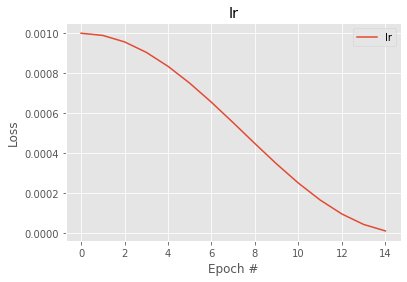

In [56]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['lr'], label='lr')

    
plt.title('lr')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

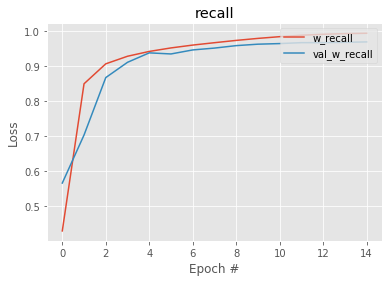

In [57]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['weighted_recall'], label='w_recall')
plt.plot(np.arange(0, epochs), history.history['val_weighted_recall'], label='val_w_recall')
    
plt.title('recall')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()